In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytz
import re
import nltk
import ast
import string
import itertools
import seaborn as sns
from datetime import datetime,timedelta
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('../Cleaning/Clean_Dataset.csv', encoding='utf-8')
jakarta = pytz.timezone('Asia/Jakarta')
time_date = "%m/%d/%Y %H:%M"
df['datetime_created'] = df['Datetime'].apply(lambda x:datetime.strptime(x,time_date))
df['date_created'] = df['datetime_created'].apply(lambda x:x.date())
df['time_created'] = df['datetime_created'].apply(lambda x:x.time())
df = df.drop(['datetime_created'],axis=1)

In [3]:
len(df)

42403

### Additional Cleaning

In [3]:
#remove duplicate
df = df.drop_duplicates()
df = df.reset_index(drop=True)

In [4]:
len(df[df['Clean_Text'].isnull() ==  True])

0

In [5]:
df = df.dropna(subset=['Clean_Text'])
df = df.reset_index(drop=True)

In [6]:
df.isnull().sum()

Datetime                 0
Tweet Id                 0
Text                     0
Username                 0
Location             25786
Clean_Text               0
indonlp_sentiment        0
Stop_Words_Text          0
Stemmed_Text             0
language                 0
Translated               0
label_score              0
score                    0
date_created             0
time_created             0
Lexicon_Score            0
Lexicon_Sentiment        0
Score_Scaled             0
label                    0
dtype: int64

In [14]:
clean_text = df['Stemmed_Text'].copy()

### Cleaning Data

In [15]:
def repair_exaggeration(x):
    word_tokens = word_tokenize(x)
    new_x =''
    for i in word_tokens:
        if (i =='metaversee'):
            new = re.sub(r'(\w)\1\1+',r'\1\1',i)
            new_x = new_x +new+' '
        elif(i =='metavers'):
            new = 'metaverse'
            new_x = new_x +new+' '
        elif(i == 'meta'):
            new = 'metaverse'
            new_x = new_x +new+' '
        else:
            new = re.sub(r'(\w)\1\1\1+',r'\1',i)
            new_x = new_x +new+' '
    return new_x

In [16]:
def del_word(x,key_list):
    n = len(key_list)
    word_tokens = word_tokenize(x)
    new_x =''
    for word in word_tokens:
        if word not in key_list:
            new_x = new_x+word+' '
    return new_x

In [17]:
#use slang and stopwords to clean the dataset
# slang and stop words source: https://github.com/louisowen6/NLP_bahasa_resources
def clean_tweets(text):
    my_file = open('../Cleaning/cleaning_source/combined_stop_words.txt','r')
    content = my_file.read()
    stop_words = content.split('\n')
    file_2 = open('../Cleaning/cleaning_source/update_combined_slang_words.txt','r')
    content2 = file_2.read()
    slang_words = ast.literal_eval(content2)
    my_file.close()
    file_2.close()
    
    text = text.lower()
    # Remove url
    text = re.sub(r'https?://[^\s]+','',text)
    # Remove hashtag
    text = re.sub(r'#\w+','',text)
    
    text = re.sub(r':', '', text)
    text = re.sub(r'‚Ä¶', '', text)
    #replace consecutive non-ASCII characters with a space
    text = re.sub(r'[^\x00-\x7F]+',' ', text)
    
    #remove emojis from text
    #text = emoji_pattern.sub(r'',text)
    
    #remove punctuation
    text = re.sub('[^a-zA-Z]',' ', text)
    
    #remove mentio
    text=re.sub('&lt;/?.*?&gt;","&lt;&gt;','',text)
    
    #remove digits and special chars
    text = re.sub("(\\d|\\W)+"," ",text)
    
    #remove other symbol from tweet
    text = re.sub(r'â', '', text)
    text = re.sub(r'€', '', text)
    text = re.sub(r'¦', '', text)
    
    #modify slang word to make it more suitable
    word_tokens = word_tokenize(text)
    for w in word_tokens:
        if w in slang_words.keys():
            word_tokens[word_tokens.index(w)] = slang_words[w]
    
    #filter using NLTK and append it to a string
    filtered_tweet = [w for w in word_tokens if not w in stop_words]
    filtered_tweet = []
    
    #loop through condition
    for w in word_tokens:
        #check tokens against emoticons, punctuations and stopwords
        if w not in string.punctuation and w not in stop_words:
            filtered_tweet.append(w.lower())
            
    return ' '.join(filtered_tweet)

In [18]:
def count_words(x):
    words = word_tokenize(x)
    n=len(words)
    return n

In [19]:
clean_text_exag = clean_text.apply(lambda x:repair_exaggeration(x))

In [20]:
re_clean = clean_text_exag.apply(lambda x: clean_tweets(x))

### Word Processing

In [21]:
#Create Word Dictionary
word_dict = {}
for i in range(0,len(df['Clean_Text'])):
    sentence = df['Stemmed_Text'][i]
    word_token = word_tokenize(sentence)
    for j in word_token:
        if j not in word_dict:
            word_dict[j] = 1
        else:
            word_dict[j] += 1

In [22]:
len(word_dict)

33096

In [23]:
len({k:v for (k,v) in word_dict.items() if v <4})

24233

# Import Lexicon Data
##### sources:

https://github.com/louisowen6/NLP_bahasa_resources
https://github.com/abhimantramb/elang/blob/master/word2vec/utils/swear-words.txt
https://github.com/fajri91/InSet
https://github.com/agusmakmun/SentiStrengthID/blob/master/id_dict/sentimentword.txt

In [24]:
negasi = ['bukan','tidak','ga','gk','g', 'ngga', 'nggak', 'no']
lexicon = pd.read_csv('Lexicon Dictionary/modified_full_lexicon.csv')
lexicon = lexicon.drop(lexicon[(lexicon['word'] == 'bukan')|
                               (lexicon['word'] == 'tidak')|
                               (lexicon['word'] == 'ga')|
                               (lexicon['word'] == 'gk')|
                               (lexicon['word'] == 'ngga')|
                               (lexicon['word'] == 'nggak')|
                               (lexicon['word'] == 'no')|
                               (lexicon['word'] == 'gk')].index,axis=0)
lexicon = lexicon.reset_index(drop=True)

In [25]:
len(lexicon)

10245

In [26]:
lexicon_word = lexicon['word'].to_list()
lexicon_num_words = lexicon['number_of_words']

In [27]:
#Check if there is words in dictionary that doesn't included in lexicon
#cek jika terdapat kata pada kamus yang tidak terdapat pada kamus lexicon
ns_words = []
#create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()
for word in word_dict.keys():
    if word not in lexicon_word:
        #kata_dasar = stemmer.stem(word)
        #if kata_dasar not in lexicon_word:
        ns_words.append(word)

In [28]:
print(len(word_dict))
print(len(lexicon))
print(len(ns_words))

33096
10245
30125


In [29]:
ns_words_list = { k:v for (k,v) in word_dict.items() if ((k in ns_words) & (v>3)) }

In [30]:
#sort the most occurences word descending
sort_orders = sorted(ns_words_list.items(), key=lambda x: x[1], reverse = True)
sort_orders = sort_orders[0:20]
for i in sort_orders:
    print(i[0], i[1])

metaverse 44908
tidak 8494
virtual 2532
teknologi 2223
nft 2168
bicara 2014
pakai 2001
nya 1998
digital 1992
bikin 1783
fotokopi 1603
era 1587
meta 1292
konsep 1280
kan 1186
bukan 1065
tanah 1027
ktp 1021
zaman 1011
bangun 986


In [31]:
word_to_plot = df['Stemmed_Text'].copy()

In [32]:
word_to_plot_1 = word_to_plot.apply(lambda x: del_word(x,negasi))

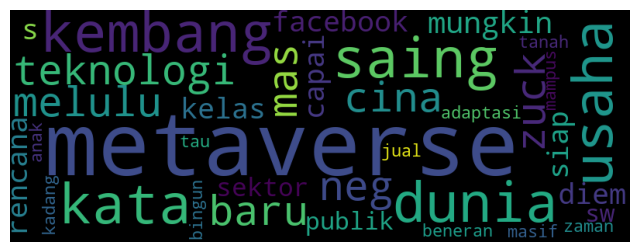

In [33]:
#create a word cloud to see which words that appear often in tweets of metaverse
wordcloud = WordCloud(width = 800, height = 300, background_color = 'black', 
                      max_words = 1000, min_font_size = 20).generate(str(word_to_plot_1))
#plot the word cloud
fig = plt.figure(figsize = (8,8), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Sentiment

In [34]:
lexicon

,word,weight,number_of_words
0,hai,3,1
1,merekam,2,1
2,ekstensif,3,1
3,paripurna,1,1
4,detail,2,1
...,...,...,...
10240,sontoloyo,-5,1
10241,tai,-5,1
10242,telek,-5,1
10243,tolol,-5,1


In [35]:
lexicon['number_of_words'].value_counts()

1    9533
2     686
3      24
4       2
Name: number_of_words, dtype: int64

#calculate sentiment words by matching them to the lexicon dictionary while creating the bag of words matrix

In [73]:
sencol =[]
senrow =np.array([])
nsen = 0
factory = StemmerFactory()
stemmer = factory.create_stemmer()
sentiment_list = []
# function to write the word's sentiment if it is founded
def found_word(ind,words,word,sen,sencol,sentiment,add):
    # if it is already included in the bag of words matrix, then just increase the value
    if word in sencol:
        sen[sencol.index(word)] += 1
    else:
    #if not, than add new word
        sencol.append(word)
        sen.append(1)
        add += 1
    #if there is a negation word before it, the sentiment would be the negation of it's sentiment
    if (words[ind-1] in negasi):
        sentiment += -lexicon['weight'][lexicon_word.index(word)]
    else:
        sentiment += lexicon['weight'][lexicon_word.index(word)]
    
    return sen,sencol,sentiment,add

In [81]:
# checking every words, if they are appear in the lexicon, and then calculate their sentiment if they do
for i in range(len(df)):
    nsen = senrow.shape[0]
    words = word_tokenize(df['Stemmed_Text'][i])
    sentiment = 0 
    add = 0
    prev = [0 for ii in range(len(words))]
    n_words = len(words)
    if len(sencol)>0:
        sen =[0 for j in range(len(sencol))]
    else:
        sen =[]
    
    for word in words:
        ind = words.index(word)
        # check whether they are included in the lexicon
        if word in lexicon_word :
            sen,sencol,sentiment,add= found_word(ind,words,word,sen,sencol,sentiment,add)
        else:
        # if not, then check the root word
            #kata_dasar = stemmer.stem(word)
            #if kata_dasar in lexicon_word:
            if word in lexicon_word:
                #sen,sencol,sentiment,add= found_word(ind,words,kata_dasar,sen,sencol,sentiment,add)
                pass
        # if still negative, try to match the combination of words with the adjacent words
            elif(n_words>1):
                if ind-1>-1:
                    back_1    = words[ind-1]+' '+word
                    if (back_1 in lexicon_word):
                        sen,sencol,sentiment,add= found_word(ind,words,back_1,sen,sencol,sentiment,add)
                    elif(ind-2>-1):
                        back_2    = words[ind-2]+' '+back_1
                        if back_2 in lexicon_word:
                            sen,sencol,sentiment,add= found_word(ind,words,back_2,sen,sencol,sentiment,add)
    # if there is new word founded, then expand the matrix
    if add>0:  
        if i>0:
            if (nsen==0):
                senrow = np.zeros([i,add],dtype=int)
            elif(i!=nsen):
                padding_h = np.zeros([nsen,add],dtype=int)
                senrow = np.hstack((senrow,padding_h))
                padding_v = np.zeros([(i-nsen),senrow.shape[1]],dtype=int)
                senrow = np.vstack((senrow,padding_v))
            else:
                padding =np.zeros([nsen,add],dtype=int)
                senrow = np.hstack((senrow,padding))
            senrow = np.vstack((senrow,sen))
        if i==0:
            senrow = np.array(sen).reshape(1,len(sen))
    # if there isn't then just update the old matrix
    elif(nsen>0):
        senrow = np.vstack((senrow,sen))
        
    sentiment_list.append(sentiment)

In [82]:
len(sentiment_list)

42403

In [83]:
print(senrow.shape[0])

42403


In [84]:
sencol.append('lexicon_sentiment')
sentiment_array = np.array(sentiment_list).reshape(senrow.shape[0],1)
sentiment_data = np.hstack((senrow,sentiment_array))
df_sen = pd.DataFrame(sentiment_data,columns = sencol)

In [85]:
df_sen.head(10)

,kembang,usaha,dunia,kata,down,melulu,mungkin,rencana,siap,diem,...,antap,subversif,pangkat,fakboi,jotos,lengah,badung,suri,alim,lexicon_sentiment
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-7
2,0,0,0,0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,10
3,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,20
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10
5,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
8,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
9,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1


In [86]:
#df_sen = df_sen.drop(df_sen.columns[0], axis=1)

In [87]:
df_sen.head()

,kembang,usaha,dunia,kata,down,melulu,mungkin,rencana,siap,diem,...,antap,subversif,pangkat,fakboi,jotos,lengah,badung,suri,alim,lexicon_sentiment
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-7
2,0,0,0,0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,10
3,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,20
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10


In [88]:
cek_df = pd.DataFrame([])
cek_df['text'] = df['Clean_Text'].copy()
cek_df['lexicon_sentiment'] = df_sen['lexicon_sentiment'].copy()

In [115]:
cek_df.head(10)

,text,lexicon_sentiment
0,cina dan as terus bersaing mengembangkan tekno...,5
1,katanya mau metaverse tapi down melulu bagaima...,-7
2,mungkin facebook sudah berencana menjadi metav...,10
3,bersaing dengan perusahaan kelas dunia untuk m...,20
4,metaverse belum diadaptasi masif masih terus d...,10
5,sama sama semoga selalu terhindar dari usaha t...,2
6,industri metaverse ini kenaikan sahamnya gede ...,4
7,industri metaverse memang sangat menjanjikan,4
8,perusahaan teknologi besar china sudah mengerj...,-1
9,dunia metaverse ini dikembangkan mengunakan te...,-1


In [90]:
df['Lexicon_Score'] = cek_df['lexicon_sentiment']

In [91]:
print(max(df['Lexicon_Score']))
print(min(df['Lexicon_Score']))

40
-35


In [92]:
scaler = MinMaxScaler()
sentiment_scores = df['Lexicon_Score'].values

In [93]:
scale_score = scaler.fit_transform(sentiment_scores.reshape(-1,1))

In [94]:
df['Score_Scaled'] = scale_score

In [95]:
def sentiment(score):
    if score >= 0.75:
        return 'positive'
    elif score <= 0.25:
        return 'negative'
    else:
        return 'neutral'

In [96]:
df['Lexicon_Sentiment'] = df['Score_Scaled'].apply(lambda x: sentiment(x))

In [97]:
X = df['Clean_Text']
y = df['Lexicon_Sentiment']

x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=42)

In [98]:
y_true = df['indonlp_sentiment'][:round(len(df)*0.2)]
y_pred = df['Lexicon_Sentiment'][:round(len(df)*0.2)]

In [99]:
# Calculate the accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

In [116]:
# Print the results
print('Accuracy: {:.2f}%'.format(accuracy * 100))
print('Precision: {:.2f}%'.format(precision * 100))
print('Recall: {:.2f}%'.format(recall * 100))
print('F1-score: {:.2f}%'.format(f1 * 100))

Accuracy: 54.78%
Precision: 61.69%
Recall: 33.69%
F1-score: 24.37%


In [101]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def sentiment(score, pos_threshold, neg_threshold):
    if score >= pos_threshold:
        return 'positive'
    elif score <= neg_threshold:
        return 'negative'
    else:
        return 'neutral'

def find_best_threshold(df):
    pos_thresholds = np.arange(0.4, 1, 0.05)
    neg_thresholds = np.arange(0, 0.3, 0.05)
    best_pos_threshold = 0
    best_neg_threshold = 0
    best_accuracy = 0
    for pos_threshold in pos_thresholds:
        for neg_threshold in neg_thresholds:
            df['predicted_sentiment'] = df['Score_Scaled'].apply(lambda x: sentiment(x, pos_threshold, neg_threshold))
            y_true = df['indonlp_sentiment'][:round(len(df)*0.2)]
            y_pred = df['predicted_sentiment'][:round(len(df)*0.2)]
            accuracy = accuracy_score(y_true, y_pred)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_pos_threshold = pos_threshold
                best_neg_threshold = neg_threshold
    return best_pos_threshold, best_neg_threshold, best_accuracy

best_pos_threshold, best_neg_threshold, best_accuracy = find_best_threshold(df)
print('Best positive threshold: {:.2f}'.format(best_pos_threshold))
print('Best negative threshold: {:.2f}'.format(best_neg_threshold))
print('Best accuracy: {:.2f}%'.format(best_accuracy * 100))

# Apply the best thresholds to predict sentiment
df['predicted_sentiment'] = df['Score_Scaled'].apply(lambda x: sentiment(x, best_pos_threshold, best_neg_threshold))

# Calculate the accuracy, precision, recall, and F1-score
y_true = df['indonlp_sentiment'][:round(len(df)*0.2)]
y_pred = df['predicted_sentiment'][:round(len(df)*0.2)]
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Print the results
print('Accuracy: {:.2f}%'.format(accuracy * 100))
print('Precision: {:.2f}%'.format(precision * 100))
print('Recall: {:.2f}%'.format(recall * 100))
print('F1-score: {:.2f}%'.format(f1 * 100))


Best positive threshold: 0.85
Best negative threshold: 0.25
Best accuracy: 54.78%
Accuracy: 54.78%
Precision: 61.69%
Recall: 33.69%
F1-score: 24.37%


In [102]:
#df.to_csv('../Cleaning/Clean_Dataset.csv', index=False)

In [103]:
df.shape

(42403, 20)

#### EDA

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_29388\3571692777.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_sen['lexicon_sentiment'], color='m', shade=True)


Text(0.5, 0, 'sentiment')

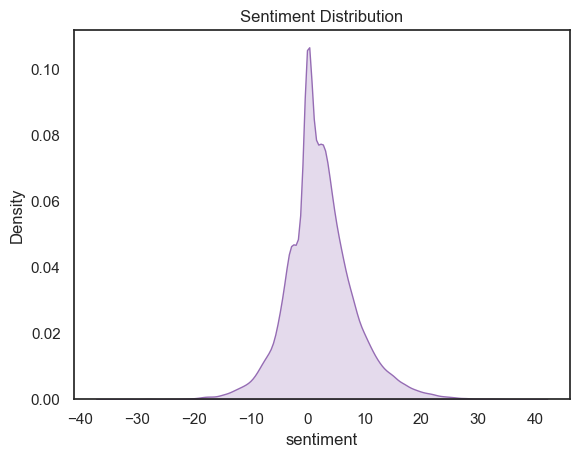

In [106]:
sns.set(style='white', palette='muted', color_codes=True)
sns.kdeplot(df_sen['lexicon_sentiment'], color='m', shade=True)
plt.title('Sentiment Distribution')
plt.xlabel('sentiment')

In [108]:
df_sen.head()

,kembang,usaha,dunia,kata,down,melulu,mungkin,rencana,siap,diem,...,antap,subversif,pangkat,fakboi,jotos,lengah,badung,suri,alim,lexicon_sentiment
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-7
2,0,0,0,0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,10
3,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,20
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10


In [111]:
top15_word = df_sen.drop(['lexicon_sentiment'], axis=1).sum().sort_values(ascending=False)[0:15]

### Beyond Words

In [117]:
#pass the sentiment into the original dataset and explore some data
df['Lexicon_Score'] = df_sen['lexicon_sentiment']

In [118]:
df.sample(15)

,Datetime,Tweet Id,Text,Username,Location,Clean_Text,indonlp_sentiment,Stop_Words_Text,Stemmed_Text,language,Translated,label_score,score,date_created,time_created,Lexicon_Score,Lexicon_Sentiment,Score_Scaled,label,predicted_sentiment
38088,9/2/2022 8:20,1.570000e+18,Menkominfo @PlateJohnny Dorong Pemanfaatan Tek...,Ddwie5,NaN,menkominfo dorong pemanfatan teknologi web unt...,neutral,menkominfo dorong pemanfatan teknologi web tin...,menkominfo dorong pemanfatan teknologi web tin...,af,The Minister of Communication and Information ...,"[{'label': 'neutral', 'score': 0.9950461387634...",0.995046,2022-09-02,08:20:00,10,neutral,0.600000,neutral,neutral
5163,12/22/2021 19:00,1.470000e+18,@abangbangbang Lebih penting sepertinya doa if...,ObiWan_Catnobi,NaN,lebih penting sepertinya doa iftitah di metave...,neutral,doa iftitah metaverse pakai alahuakbar kabiro ...,doa iftitah metaverse pakai alahuakbar kabiro ...,id,Prayer iftitah metverse uses Allahuakbar kabir...,"[{'label': 'neutral', 'score': 0.9794986844062...",0.979499,2021-12-22,19:00:00,4,neutral,0.520000,neutral,neutral
14688,1/19/2022 15:11,1.480000e+18,@AmirKagawa Tunggu metaverse letak rigging kak...,mohdsein,NaN,tunggu metaverse letak riging kaki ahahah kita...,negative,tunggu metaverse letak riging kaki ahahah shuf...,tunggu metaverse letak riging kaki ahahah shuf...,id,Wait for Metaverse the location of the rigging...,"[{'label': 'negative', 'score': 0.684137165546...",0.684137,2022-01-19,15:11:00,1,neutral,0.480000,negative,neutral
33310,5/28/2022 23:34,1.530000e+18,@nuicemedia Kaya gini ko mau ngomongin metaverse,emyugblk,Cilacap,kaya gini ko mau membicarakan metaverse,negative,kaya gini ko membicarakan metaverse,kaya gin ko bicara metaverse,id,"like this, talking about Metaverse","[{'label': 'negative', 'score': 0.998310327529...",0.998310,2022-05-28,23:34:00,2,neutral,0.493333,negative,neutral
26857,4/6/2022 23:17,1.510000e+18,@luniverseworld tempat metaverse yang bagus un...,dingkawnnabis,Jakarta.Indonesia,tempat metaverse yang bagus untuk bersama,positive,metaverse bagus,metaverse bagus,no,good metaverse,"[{'label': 'positive', 'score': 0.997562408447...",0.997562,2022-04-06,23:17:00,2,neutral,0.493333,positive,neutral
7373,12/25/2021 13:07,1.470000e+18,"Krain gk bisa nge tag willi doang di ig, trnyt...",mizone_xoxo,NaN,krain tidak bisa tag wili doang di ig trnyta s...,negative,krain tidak tag wili doang ig trnyta slain wil...,krain tidak tag wili doang ig trnyta slain wil...,id,"Krain, I don't tag Willi, IG TRNYTA SLAIN WILL...","[{'label': 'negative', 'score': 0.995988786220...",0.995989,2021-12-25,13:07:00,-3,neutral,0.426667,negative,neutral
22370,2/26/2022 0:11,1.500000e+18,@Jokitugsfess aku paham dan tertarik bangettt ...,yuliahadi_,Asahan,aku paham dan tertarik banget dengan topik met...,positive,paham tertarik banget topik metaverse coba dm ...,paham tarik banget topik metaverse coba dm fen...,id,Understanding is really interested in the topi...,"[{'label': 'positive', 'score': 0.783324301242...",0.783324,2022-02-26,00:11:00,5,neutral,0.533333,positive,neutral
40563,10/29/2022 13:16,1.590000e+18,Eropa musim dingin tanpa listrik dan gas. Rawa...,DokterTifa,NaN,eropa musim dingin tanpa listrik dan gas rawan...,negative,eropa musim dingin listrik gas rawan pangan me...,eropa musim dingin listrik gas rawan pangan ba...,id,European Winter Electricity Food -prone gas sh...,"[{'label': 'negative', 'score': 0.991071224212...",0.991071,2022-10-29,13:16:00,-10,neutral,0.333333,negative,neutral
27238,4/12/2022 10:50,1.510000e+18,Nikmati kabar singkat dan padat seputar blockc...,Vingika,"Medan, Indonesia",nikmati kabar singkat dan padat seputar blockc...,neutral,nikmati kabar singkat padat seputar blockchain...,nikmat kabar singkat padat putar blockchain kr...,sv,Enjoy short news about the crypto NFT Metavers...,"[{'label': 'neutral', 'score': 0.9938363432884...",0.993836,2022-04-12,10:50:00,2,neutral,0.493333,neutral,neutral
38444,9/11/2022 8:27,1.570000e+18,"@PNS_Ab

In [119]:
df_location = df.groupby(['Location']).mean().sort_values(by='Lexicon_Score',ascending=False)
df_location = df_location.reset_index()

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_29388\3105219852.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_location = df.groupby(['Location']).mean().sort_values(by='Lexicon_Score',ascending=False)


In [120]:
df_location_dict = df.groupby(['Location']).count().sort_values(by='Tweet Id',ascending=False)['Tweet Id'].to_dict()

In [121]:
df_location['number_of_tweets'] =  df_location.apply(lambda x:df_location_dict[x['Location']],axis=1)

In [122]:
top10_location_positive = df_location.sort_values(by='Lexicon_Score', ascending=False)[0:10].reset_index(drop=True)
top10_location_negative = df_location.sort_values(by='Lexicon_Score', ascending=True)[0:10].reset_index(drop=True)
top10_location = df_location.sort_values(by='number_of_tweets', ascending=False)[0:10].reset_index(drop=True)

C:\Users\Juniarta\anaconda3\envs\tf\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 159 (\x9f) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Juniarta\anaconda3\envs\tf\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 135 (\x87) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


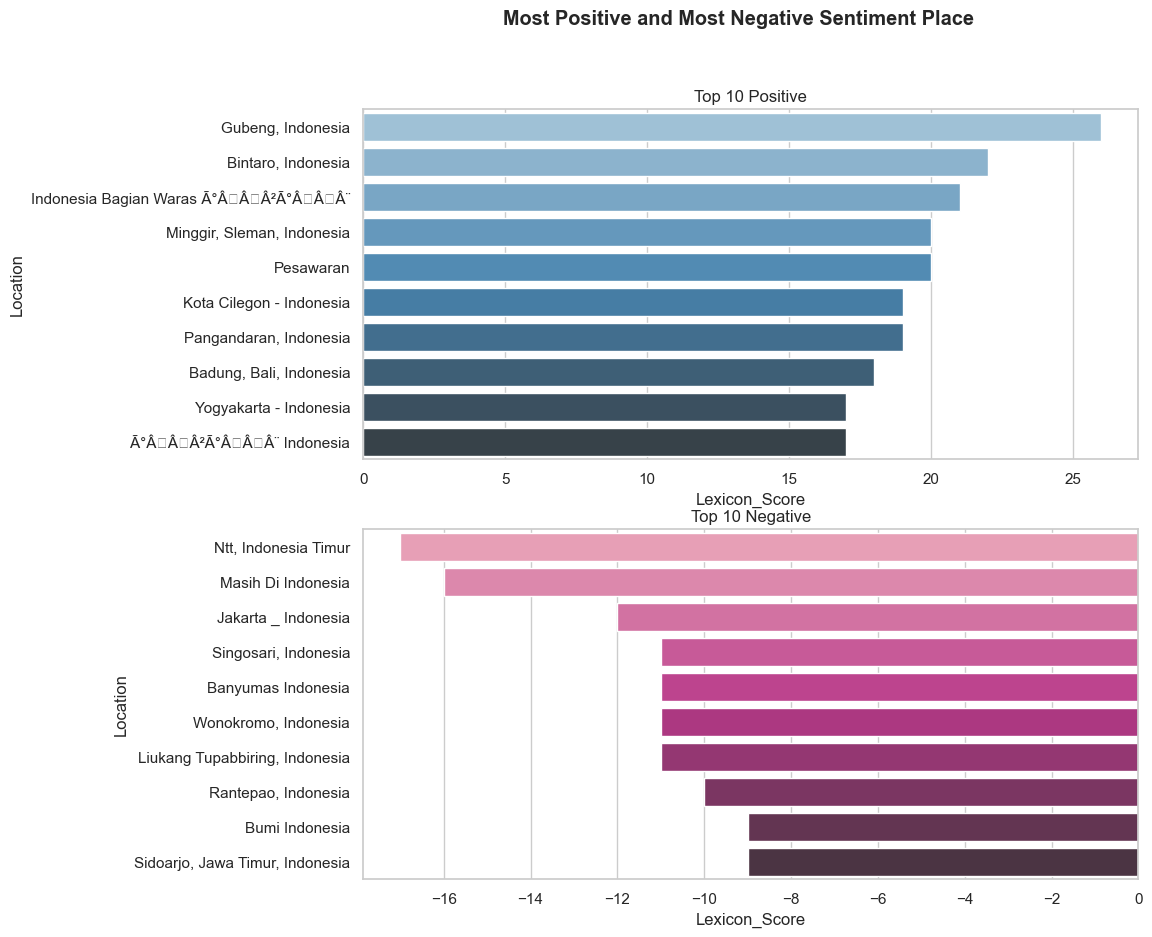

In [123]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(10,10))
fig.suptitle('Most Positive and Most Negative Sentiment Place', fontweight='bold')
h = sns.barplot(y='Location', x='Lexicon_Score', data=top10_location_positive, ax=ax1, palette=sns.color_palette('Blues_d', n_colors=10))
n = sns.barplot(y='Location', x='Lexicon_Score', data=top10_location_negative, ax=ax2, palette=sns.color_palette('RdPu_d', n_colors=10))
ax1.set_title('Top 10 Positive')
ax2.set_title('Top 10 Negative')
plt.show()

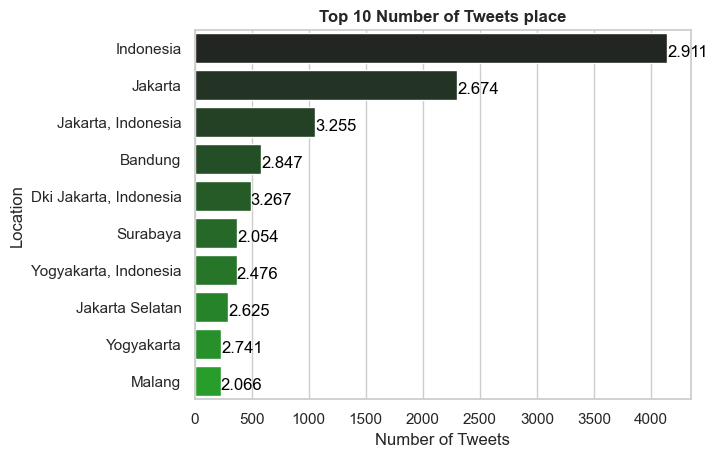

In [125]:
#place where tweets is most often come from
pal =sns.dark_palette("green", input="xkcd",n_colors=10)
g = sns.barplot(y = top10_location['Location'] , x = top10_location['number_of_tweets'],palette=pal)
g.grid=False
plt.xlabel('Number of Tweets')
plt.ylabel('Location')
plt.title("Top 10 Number of Tweets place",fontweight='bold') 

for i in range(10):
    g.text(top10_location['number_of_tweets'][i], i+0.22 ,round(top10_location['Lexicon_Score'][i],3),color='black')
    
plt.show()